随便设置一个奖励序列。

In [1]:
import numpy as np

gamma = 0.9
R = np.array([1., 1., 0., 0., 1., 4., 0., 0., 0., 2.], dtype=np.float32)
R

array([1., 1., 0., 0., 1., 4., 0., 0., 0., 2.], dtype=float32)

用 numpy 先采样一个服从 Normal 分布的矩阵，再对它取绝对值并归一化，得到一随机转移矩阵。

In [2]:
np.set_printoptions(suppress=True)
P = np.random.randn(10, 10)
P = np.abs(P)
P = P / P.sum(axis=1, keepdims=True)
P.round(2)

array([[0.05, 0.08, 0.06, 0.23, 0.  , 0.07, 0.11, 0.14, 0.04, 0.23],
       [0.07, 0.03, 0.03, 0.04, 0.19, 0.01, 0.32, 0.17, 0.11, 0.03],
       [0.09, 0.15, 0.08, 0.13, 0.05, 0.12, 0.1 , 0.21, 0.  , 0.07],
       [0.01, 0.03, 0.04, 0.25, 0.07, 0.2 , 0.17, 0.02, 0.07, 0.15],
       [0.08, 0.01, 0.23, 0.07, 0.15, 0.05, 0.01, 0.07, 0.06, 0.26],
       [0.16, 0.17, 0.16, 0.03, 0.12, 0.09, 0.08, 0.04, 0.08, 0.06],
       [0.11, 0.14, 0.05, 0.13, 0.05, 0.13, 0.03, 0.17, 0.13, 0.08],
       [0.11, 0.12, 0.14, 0.15, 0.13, 0.06, 0.02, 0.  , 0.2 , 0.06],
       [0.2 , 0.04, 0.06, 0.06, 0.14, 0.07, 0.01, 0.12, 0.04, 0.25],
       [0.11, 0.22, 0.08, 0.19, 0.03, 0.12, 0.04, 0.  , 0.11, 0.08]])

理论上，价值函数的解析解可以通过 V = (I - gamma * P)^-1 @ R 求得，前提是奖励向量 R 和状态转移 P 都已知。

In [3]:
I = np.eye(N=10)
V = np.linalg.inv(I - gamma * P) @ R
V.round(2)

array([ 9.28,  8.83,  8.25,  8.62,  9.39, 12.25,  8.32,  8.16,  8.54,
       10.37])

贝尔曼方程是一种迭代的估计，用 s' 的价值期望估计当前 s 的价值期望，单次价值更新是解一次重叠子问题；价值函数的最优是对每个状态的回报 g 估计最准确，因此子问题是对某些采样到的状态估计准确；故而符合最优子结构。价值函数可以存储并重用子问题的最佳的解。

如下是斐波那契数列的两种实现。第一种自顶向下，并递归分解问题。

In [4]:
def fib(n, memo={}):
    if n <= 1:
        return n
    if n not in memo:
        memo[n] = fib(n-1, memo) + fib(n-2, memo)
    return memo[n]
    
fib(10)

55

第二种自底向上，按照子问题规模由小到大依次计算，并用数组（或表）记录结果。

In [5]:
def fib(n):
    if n <= 1:
        return n
    dp = [0] * (n+1)
    dp[0], dp[1] = 0, 1
    for i in range(2, n+1):
        dp[i] = dp[i-1] + dp[i-2]
    return dp[n]
    
fib(10)

55

我们从强化学习的语境重新理解斐波那契数列问题。在任意确定性链式 MDP 中，若你观测到价值函数 V_i = F_i，那么奖励必定满足 r_i = F_i - gamma * F_{i+1}。我们可以奖励函数反推出来。

In [6]:
N = 10
Fib = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
gamma = 0.99

R = []
for i in range(len(Fib)):
    next_fib = Fib[i+1] if i+1 < len(Fib) else 0
    R.append(Fib[i] - gamma * next_fib)
    
np.array(R, dtype=np.float32)

array([ -0.99,   0.01,  -0.98,  -0.97,  -1.95,  -2.92,  -4.87,  -7.79,
       -12.66,  34.  ], dtype=float32)

如下是计算马尔可夫奖励过程价值的动态规划算法，即贝尔曼方程迭代求解。

In [7]:
P = np.eye(10)
P[:-1] = P[1:]
P[-1] = np.zeros(10)
P

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

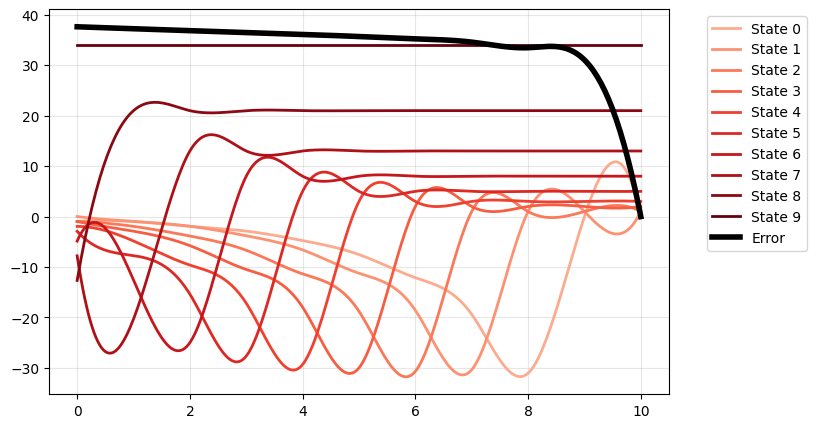

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

V = np.zeros(10)
V_history = []
error_history = []

for k in range(100):
    V_old = V.copy()
    V = R + gamma * P @ V
    error = np.linalg.norm(V - V_old)
    
    V_history.append(V.copy())
    error_history.append(error)

    if error < 1e-5:
        break

V_history = np.array(V_history)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
colors = plt.cm.Reds(np.linspace(0.3, 1.0, 10))

x = np.arange(len(V_history))
x_smooth = np.linspace(x.min(), x.max(), 300)

for i in range(10):
    if len(x) > 3:
        spline = make_interp_spline(x, V_history[:, i], k=3)
        y_smooth = spline(x_smooth)
        ax1.plot(x_smooth, y_smooth, color=colors[i], linewidth=2, label=f'State {i}')
    else:
        ax1.plot(V_history[:, i], color=colors[i], linewidth=2, label=f'State {i}')

if len(x) > 3:
    error_spline = make_interp_spline(x, error_history, k=3)
    error_smooth = error_spline(x_smooth)
    ax1.plot(x_smooth, error_smooth, color='black', linewidth=4, label='Error')
else:
    ax1.plot(error_history, color='black', linewidth=4, label='Error')

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
plt.show()

In [9]:
V.round(3), np.array(Fib, dtype=float)

(array([ 0.,  1.,  1.,  2.,  3.,  5.,  8., 13., 21., 34.]),
 array([ 0.,  1.,  1.,  2.,  3.,  5.,  8., 13., 21., 34.]))

同步备份是指每一次的迭代都会完全更新所有的状态，这对于程序资源的需求特别大。异步备份（asynchronous backup）的思想就是通过某种方式，使得每一次迭代不需要更新所有的状态，因为事实上，很多状态也不需要被更新。

策略迭代：
- 用 π 迭代更新估计 V 和 Q；
- $Q_{\pi}(s, a)=R(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V_{\pi}\left(s^{\prime}\right)$
- $V_{\pi}(s)=\sum_{a \in A} \pi(a \mid s)\left(R(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V_{\pi}\left(s^{\prime}\right)\right)$
- 再直接对 Q 函数进行最大化，通过在 Q 函数做贪心搜索来进一步改进策略；
- $\pi_{i+1}(s)=\underset{a}{\arg \max } Q_{\pi_{i}}(s, a)$
- 不断迭代收敛，最后得到 Q 和 V 的贝尔曼最优平稳方程；
- 此时，V 表是 Q 表中的一条 max 的采样。

价值迭代：
- 直接把贝尔曼最优方程当成一个更新规则来进行，每次在 s 采样可能的 a，并取其中最大的价值进行更新；
- $V(s) \leftarrow \max _{a \in A}\left(R(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V\left(s^{\prime}\right)\right)$
- 不停地迭代贝尔曼最优方程，价值函数就能逐渐趋向于最佳的价值函数，这是价值迭代算法的精髓。